# Pip Installs

In [20]:
!pip install opencv-python
!pip install torch
!pip install torchaudio
!pip install numpy
!pip install pandas
!pip install pydub
!pip install ffmpeg
!pip install librosa
!pip install soundfile
!add-apt-repository -y ppa:savoury1/ffmpeg4
!apt-get -qq install -y ffmpeg

Repository: 'deb https://ppa.launchpadcontent.net/savoury1/ffmpeg4/ubuntu/ jammy main'
Description:
FFmpeg 4.4.6 builds (& associated multimedia packages) for Xenial & newer.

*** Anyone interested in full builds of FFmpeg 4.4.x including all "bells and whistles" needs to have donated, after which access to the new private PPA can be requested. See my Launchpad page linked below for details. ***

*** Please always see https://launchpad.net/~savoury1 for general updates about this Launchpad site before contacting me or reporting any bugs! ***

*** Big thanks to all those who have donated to support this project, you are very directly helping to keep it alive! To all who have not donated: please do so if you can afford it, this project depends on donations. ***

If software at this site is useful to you then please consider a donation:

*** Donations: https://paypal.me/Savoury1 & https://ko-fi.com/Savoury1 ***
*** Also https://patreon.com/Savoury1 & https://liberapay.com/Savoury1 ***

  

In [21]:
pip install --upgrade librosa


In [22]:
pip install "numba<0.58" "numpy<1.26"


# Imports

In [41]:
import os
import pandas as pd
from rich import print
import torchaudio
torchaudio.set_audio_backend("sox_io")
import torch
import torch.nn as nn
from torch.utils.data                        import DataLoader
from torch.utils.data import Dataset
import torch.optim                           as optim
from pydub                                   import AudioSegment
import numpy                                 as np
import librosa
import matplotlib.pyplot                     as plt
import sys
import librosa
import librosa.display
from google.colab import drive
drive.mount("/content/drive")

<ipython-input-41-ec51a79d125f>:5: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Set Path

In [24]:
path_denis = "/content/drive/My Drive/IST/musicnet"
path_goncas = "/content/drive/My Drive/musicnet"

# Output functions

In [25]:
def using_cuda():
    if torch.cuda.is_available():
        print("Using GPU for training")
    else:
        print("Using CPU for training")

DEFAULT_WIDTH  = 80
DEFAULT_RANGE  = 35
TITLE_COLOR    = "yellow"
DEFAULT_SYMBOL = '='

def print_header(title: str, args: dict = None, symbol: str = DEFAULT_SYMBOL, width: int = DEFAULT_WIDTH, param_range: int = DEFAULT_RANGE, color: str = TITLE_COLOR):
    """Prints a header for the specified section with a title."""
    print('\n')
    print(symbol * width)
    print(f"[{color}]{title.center(width)}[{color}]")
    print(symbol * width + "\n")

    # print aditional arguments
    if args is not None: print_arguments(args, param_range)

def print_arguments(args: dict, param_range: int = DEFAULT_RANGE):
    # print aditional arguments
    for key, value in args.items():
        print(f"> {key:<{param_range}}: {value}")

def print_small_header(title: str, symbol: str = DEFAULT_SYMBOL, width: int = DEFAULT_WIDTH, color: str = TITLE_COLOR):
    print(symbol * width)
    print(f"[{color}]{title.center(width)}[{color}]\n")

def print_separator(symbol: str = DEFAULT_SYMBOL, width: int = DEFAULT_WIDTH):
    print("\n" + symbol * width + "\n")

def print_update(s: str):
    print(f"{s}")

# Mel Spectogram

In [26]:
def compute_mel_spectrogram(tensor_audio, sr=22050, n_mels=128, fmax=8000):
    audio_np = tensor_audio.numpy().squeeze()
    mel = librosa.feature.melspectrogram(y=audio_np, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db

class MelSpectrogramDataset(Dataset):
    def __init__(self, data, n_notes=88, max_len=4000):  # max_len in time frames
        self.data = data
        self.n_notes = n_notes
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        mel = self.data[idx]['mel']
        label_df = self.data[idx]['label']

        mel_tensor = torch.tensor(mel, dtype=torch.float32)

        # Pad or truncate
        if mel_tensor.shape[1] > self.max_len:
            mel_tensor = mel_tensor[:, :self.max_len]
        else:
            pad_width = self.max_len - mel_tensor.shape[1]
            mel_tensor = torch.nn.functional.pad(mel_tensor, (0, pad_width))

        mel_tensor = mel_tensor.unsqueeze(0)  # Add channel dim: [1, 128, T]

        # Create multi-hot label vector
        label_vector = torch.zeros(self.n_notes)
        for note in label_df['note'].values:
            if 21 <= note <= 108:
                label_vector[note - 21] = 1.0

        return mel_tensor, label_vector

# RNN

In [27]:
class TranscriptionRNN(nn.Module):
    def __init__(self, n_notes):
        super(TranscriptionRNN, self).__init__()
        self.rnn = nn.LSTM(input_size=128, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True)
        # Bidirectional LSTM with 2 layers
        # self.rnn_dropout = nn.Dropout(0.5)
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_notes)  # Final layer for multi-label classification
        )

    def forward(self, x):
        x, _ = self.rnn(x)  # Pass through RNN layers
        # x = self.rnn_dropout(x)
        x = x[:, -1, :]  # Get the last time step output
        x = self.fc(x)  # Fully connected layers
        x = torch.sigmoid(x)  # Apply sigmoid activation to ensure output in [0, 1]
        return x

# CNN

In [28]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.skip_connection = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU()

    def forward(self, x):
        residual = self.skip_connection(x)
        x = self.conv_block(x)
        x += residual
        return self.relu(x)

class TranscriptionCNN(nn.Module):
    def __init__(self, n_notes):
        super(TranscriptionCNN, self).__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer1 = ResidualBlock(32, 64, downsample=True)
        self.layer2 = ResidualBlock(64, 128, downsample=True)
        self.layer3 = ResidualBlock(128, 256, downsample=True)
        self.layer4 = ResidualBlock(256, 512, downsample=True)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output: (B, 512, 1, 1)

        self.fc = nn.Sequential(
            nn.Flatten(),            # Shape: (B, 512)
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_notes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = self.fc(x)
        return x

# CRNN

In [70]:
from re import X
import torch.nn as nn
import torch

class TranscriptionCRNN(nn.Module):
    def __init__(self, n_notes):
        super(TranscriptionCRNN, self).__init__()

        # Convolutional layers
        self.cnn = nn.Sequential(
        nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1))  # Output size: (batch, 256, 1, 1)
        )

        # Fully connected classifier
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_notes)  # Output shape: (batch_size, n_notes)
        )

    def forward(self, x):
        # x: (batch_size, 1, height, width)
        x = self.cnn(x)           # -> (batch_size, 256, 1, 1)
        x = self.fc(x)            # -> (batch_size, n_notes)
        return x


# Data Loader

In [30]:
def load_wav_and_labels(train_audio_dir, test_audio_dir, train_label_dir, test_label_dir, load_fraction=0.20):
    data = {'train': [], 'test': []}

    def load_data(audio_dir, label_dir, split):
        wav_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
        wav_files = wav_files[:int(len(wav_files) * load_fraction)]  # Only take the first half

        for filename in wav_files:
            wav_path = os.path.join(audio_dir, filename)
            label_path = os.path.join(label_dir, filename.replace('.wav', '.csv'))

            try:
                audio, sr = torchaudio.load(wav_path)
                label = pd.read_csv(label_path) if os.path.exists(label_path) else None
                data[split].append({
                    'filename': filename,
                    'audio': audio,
                    'sr': sr,
                    'label': label
                })
            except Exception as e:
                print(f"Error loading {filename}: {e}")

    load_data(train_audio_dir, train_label_dir, 'train')
    load_data(test_audio_dir, test_label_dir, 'test')

    return data

def train_test_split_data(file_paths, labels, test_size=0.2):
    # Since we already have train/test sets, we don't need to split again here
    return file_paths['train'], file_paths['test'], labels['train'], labels['test']

# Fetch Data

In [31]:
def fetch_data(musicnet_path=path_denis):

    print_header("Finding Folder of Musicnet")

    # Path to the music_net data folder
    raw_data_file = musicnet_path

    #if os.path.exists(raw_data_file):
    #    print(f"Path found: {raw_data_file}")
    #    if not os.path.isdir(raw_data_file):
    #        print(f"Path is not a directory: {raw_data_file}")
    #        print("Please specify the correct path to the musicnet data folder.")
    #        sys.exit(1)
    #else:
    #    print(f"Path not found: {raw_data_file}")
    #    print("Please specify the correct path to the musicnet data folder.")
    #    sys.exit(1)

    return raw_data_file

# Load Split

In [32]:
def load_split(data, musicnet_path=path_denis):

    print_header("Loading all the data")

    # Define your specific paths
    train_audio_dir = os.path.join(musicnet_path, 'train_data')
    test_audio_dir = os.path.join(musicnet_path, 'test_data')
    train_label_dir = os.path.join(musicnet_path, 'train_labels')
    test_label_dir = os.path.join(musicnet_path, 'test_labels')
    # train_audio_dir = '/Users/denis/Desktop/IST/S2_24_25/PMBA/musicnet/train_data'
    # test_audio_dir = '/Users/denis/Desktop/IST/S2_24_25/PMBA/musicnet/test_data'
    # train_label_dir = '/Users/denis/Desktop/IST/S2_24_25/PMBA/musicnet/train_labels'
    # test_label_dir = '/Users/denis/Desktop/IST/S2_24_25/PMBA/musicnet/test_labels'

    # Call the function with these paths
    data = load_wav_and_labels(train_audio_dir, test_audio_dir, train_label_dir, test_label_dir)

    # Example to access loaded data for training
    train_data = data['train']
    train_data_audio = []
    train_data_labels = []

    # Loop through each entry in train_data and separate the audio and labels
    for entry in train_data:
        audio = entry['audio']  # This will be the tensor with audio data
        label = entry['label']  # This will be the DataFrame with the labels

        # Append the audio and label to their respective lists
        train_data_audio.append(audio)
        train_data_labels.append(label)
    print(f"Number of training samples: {len(train_data)}")
    print(train_data_audio[0])

    # Example to access loaded data for testing
    test_data = data['test']
    test_data_audio = []
    test_data_labels = []

    print(f"Number of testing samples: {len(test_data)}")
    # Loop through each entry in train_data and separate the audio and labels
    for entry in test_data:
        audio = entry['audio']  # This will be the tensor with audio data
        label = entry['label']  # This will be the DataFrame with the labels

        # Append the audio and label to their respective lists
        test_data_audio.append(audio)
        test_data_labels.append(label)

    print(test_data_audio[0])

    return train_data_audio, train_data_labels, test_data_audio, test_data_labels

# Spectogram

In [33]:
def prepare_data_and_compute_spectogram(train_data_audio, train_data_labels, test_data_audio, test_data_labels):

    print_header("Applying spectrogram to the data")

    # Lists to store results
    train_mels = []
    test_mels = []

    # Process train data
    for audio_tensor in train_data_audio:
        try:
            mel_spec = compute_mel_spectrogram(audio_tensor)
            train_mels.append(mel_spec)
        except Exception as e:
            print(f"Error processing train sample: {e}")

    # Process test data
    for audio_tensor in test_data_audio:
        try:
            mel_spec = compute_mel_spectrogram(audio_tensor)
            test_mels.append(mel_spec)
        except Exception as e:
            print(f"Error processing test sample: {e}")

    print_update("Plotting Spectrogram of the First 3 samples")

    for i, mel in enumerate(train_mels[:3]):  # Just plot first 3
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel, sr=22050, x_axis='time', y_axis='mel', fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Train Sample {i} - Mel Spectrogram')
        plt.tight_layout()
        plt.show()

    # Create a new dataset combining mel spectrograms with labels
    train_dataset = [{'mel': mel, 'label': label} for mel, label in zip(train_mels, train_data_labels)]
    test_dataset  = [{'mel': mel, 'label': label} for mel, label in zip(test_mels, test_data_labels)]

    return train_dataset, test_dataset


# Data With Audio Only (No spectogram)

In [34]:
def prepare_audio_data_without_spectrogram(train_data_audio, train_data_labels, test_data_audio, test_data_labels):
    print_header("Preparing audio data without spectrogram")

    # Create a new dataset combining audio with labels
    train_dataset = [{'audio': audio, 'label': label} for audio, label in zip(train_data_audio, train_data_labels)]
    test_dataset  = [{'audio': audio, 'label': label} for audio, label in zip(test_data_audio, test_data_labels)]

    return train_dataset, test_dataset

# CNN training

In [35]:
def train_CNN(train_dataset, test_dataset):

    print_header("Initialize the model")

    train_dataset = MelSpectrogramDataset(train_dataset, n_notes=88)
    test_dataset = MelSpectrogramDataset(test_dataset, n_notes=88)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


    cuda_model = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check for GPU
    using_cuda()
    model = TranscriptionCNN(n_notes=88).to(cuda_model)  # Adjust for the number of notes (88 for piano keys)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()  # Binary Cross-Entropy for multi-label classification

    # Training Loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            # Move inputs to GPU
            inputs = inputs.to(cuda_model)
            labels = labels.to(cuda_model)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    return train_loader, test_loader, model

# RNN Training

In [36]:
def train_BLSTM(train_dataset, test_dataset):
    print_header("Initialize the model")

    #train_dataset = MelSpectrogramDataset(train_dataset, n_notes=88)
    #test_dataset = MelSpectrogramDataset(test_dataset, n_notes=88)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    cuda_model = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check for GPU
    using_cuda()
    model = TranscriptionRNN(n_notes=88).to(cuda_model)  # Adjust for the number of notes (88 for piano keys)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()  # Binary Cross-Entropy for multi-label classification

    # Training Loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    return train_loader, test_loader, model

# CRNN Training

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_CRNN(train_dataset, test_dataset, n_notes=88, num_epochs=30, batch_size=8):
    """Train a CRNN model using BCEWithLogitsLoss on Mel spectrogram data."""

    print_header("Initializing CRNN model for multi-label classification")

    # === Dataset Setup ===
    train_dataset = MelSpectrogramDataset(train_dataset, n_notes=n_notes)
    test_dataset = MelSpectrogramDataset(test_dataset, n_notes=n_notes)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # === Device & Model Setup ===
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TranscriptionCRNN(n_notes=n_notes).to(device)

    # === Optimization ===
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Often more stable

    # === Training Loop ===
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).float()  # Ensure float for BCE

            optimizer.zero_grad()
            outputs = model(inputs)  # shape: (batch, n_notes)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # === Multi-label Accuracy ===
            preds = torch.sigmoid(outputs) > 0.5
            correct = (preds == targets.bool()).sum().item()
            total = torch.numel(preds)
            running_correct += correct
            running_total += total

        avg_loss = running_loss / len(train_loader)
        accuracy = running_correct / running_total * 100
        print(f"Epoch {epoch:02d}/{num_epochs} | Loss: {avg_loss:.4f} | Train Acc: {accuracy:.2f}%")

    return train_loader, test_loader, model, device

# Model Evaluation

In [102]:
def evaluate_model(model, test_loader, device):
    print_header("Evaluate the model")

    model.eval()
    running_correct = 0
    running_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()  # Ensure float

            outputs = model(inputs)  # Raw logits
            probs = torch.sigmoid(outputs)  # Convert to probabilities
            predicted = (probs > 0.5).float()  # Threshold at 0.5

            running_correct += (predicted == labels).sum().item()
            running_total += torch.numel(labels)  # Total number of labels (batch_size * n_notes)

    accuracy = 100 * running_correct / running_total
    print(f'Accuracy on test set: {accuracy:.2f}%')

# "Main Function"

In [39]:
#path1 = "/content/drive/My Drive/IST/musicnet"
path_goncas = "/content/drive/My Drive/musicnet"

if os.path.exists(path_denis):
  print("fixe")
else:
  print(":(")

fixe

In [42]:
musicnet_path = fetch_data(path_denis)
train_data_audio, train_data_labels, test_data_audio, test_data_labels = load_split(musicnet_path)

print_header("Finished Loading")

================================================================================

                           Finding Folder of Musicnet                           

================================================================================

================================================================================

                              Loading all the data                              

================================================================================

Number of training samples: 64

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

Number of testing samples: 2

tensor([[ 0.0000e+00, -3.0518e-05,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

================================================================================

                                Finished Loading                                

================================================================================

# Call and train CNN

================================================================================

                        Applying spectrogram to the data                        

================================================================================

Plotting Spectrogram of the First 3 samples

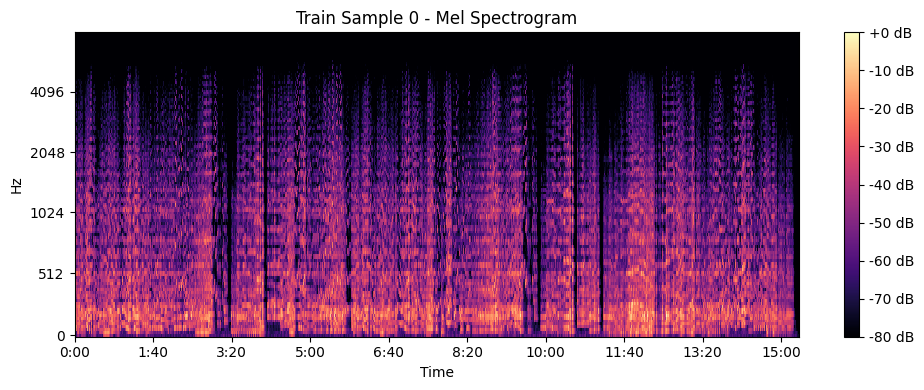

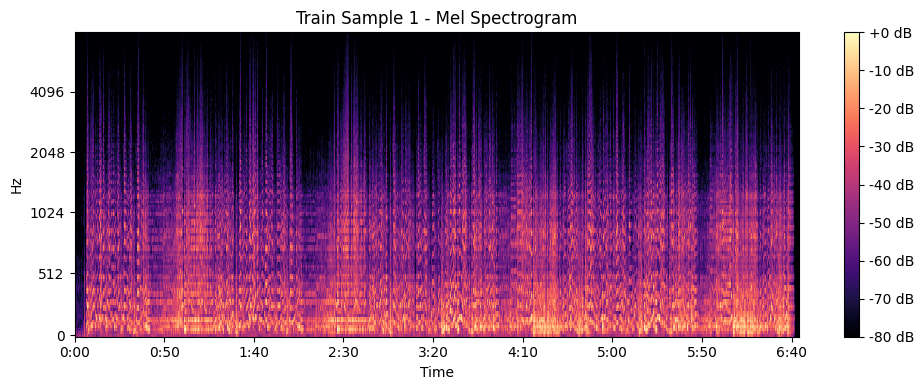

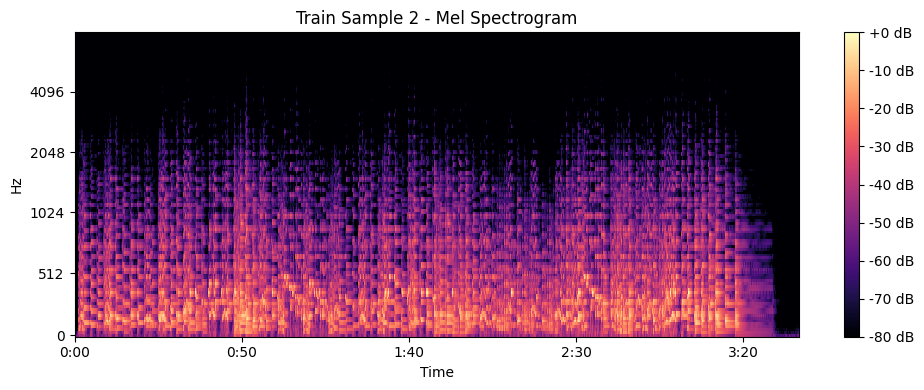

================================================================================

                              Initialize the model                              

================================================================================

Using GPU for training

TypeError: 'NoneType' object is not subscriptable

In [40]:
train_dataset, test_dataset = prepare_data_and_compute_spectogram(train_data_audio, train_data_labels, test_data_audio, test_data_labels)
train_loader, test_loader, model, device = train_CNN(train_dataset, test_dataset)

# Call and train RNN

In [ ]:
train_dataset, test_dataset = prepare_audio_data_without_spectrogram(train_data_audio, train_data_labels, test_data_audio, test_data_labels)
train_loader, test_loader, model = train_BLSTM(train_dataset, test_dataset)

# Call and train CRNN

================================================================================

                        Applying spectrogram to the data                        

================================================================================

Plotting Spectrogram of the First 3 samples

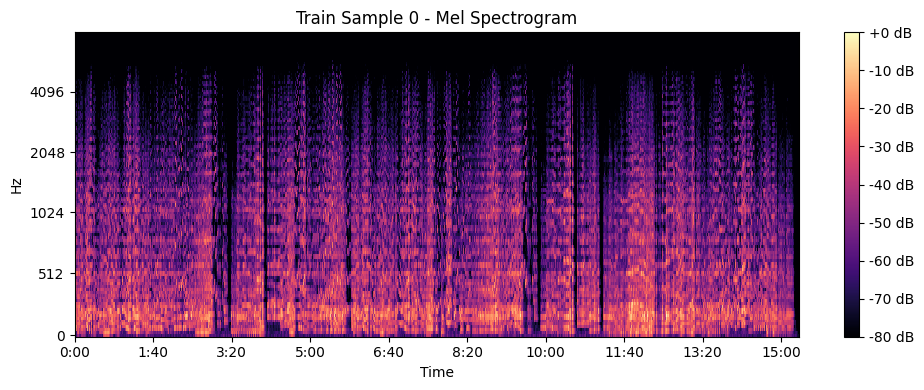

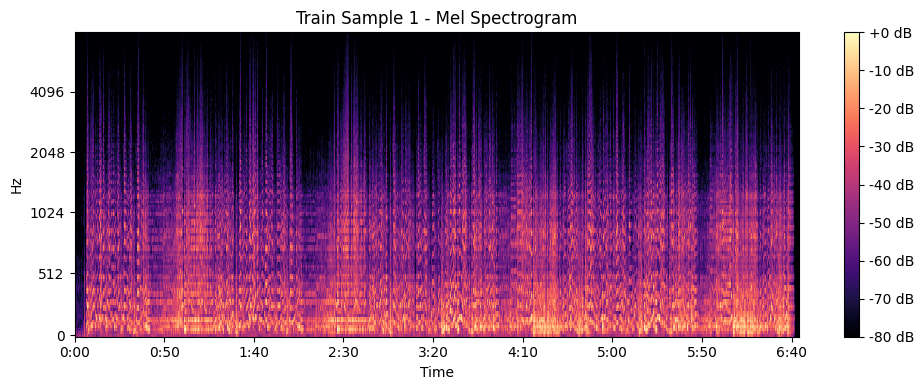

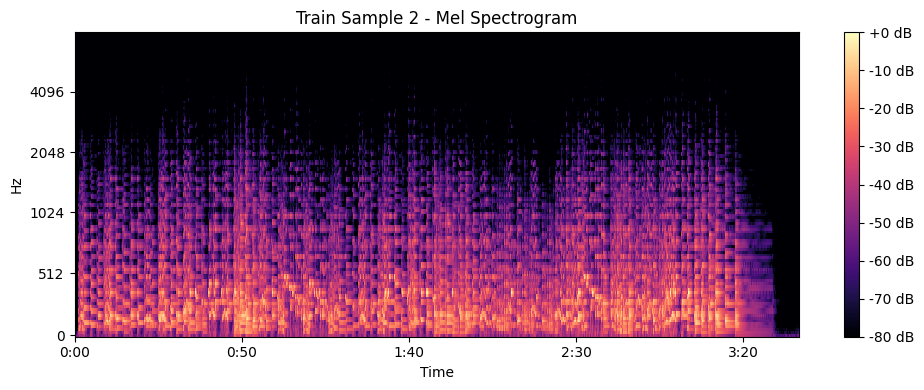

In [43]:
train_dataset, test_dataset = prepare_data_and_compute_spectogram(train_data_audio, train_data_labels, test_data_audio, test_data_labels)

In [105]:
train_loader, test_loader, model, device = train_CRNN(train_dataset, test_dataset)

================================================================================

             Initializing CRNN model for multi-label classification             

================================================================================

Epoch 01/30 | Loss: 0.6843 | Train Acc: 60.83%

Epoch 02/30 | Loss: 0.5680 | Train Acc: 70.60%

Epoch 03/30 | Loss: 0.5328 | Train Acc: 73.69%

Epoch 04/30 | Loss: 0.5068 | Train Acc: 75.57%

Epoch 05/30 | Loss: 0.4905 | Train Acc: 76.65%

Epoch 06/30 | Loss: 0.4675 | Train Acc: 78.48%

Epoch 07/30 | Loss: 0.4597 | Train Acc: 79.05%

Epoch 08/30 | Loss: 0.4496 | Train Acc: 80.01%

Epoch 09/30 | Loss: 0.4306 | Train Acc: 81.04%

Epoch 10/30 | Loss: 0.4160 | Train Acc: 81.75%

Epoch 11/30 | Loss: 0.4055 | Train Acc: 83.01%

Epoch 12/30 | Loss: 0.4001 | Train Acc: 83.75%

Epoch 13/30 | Loss: 0.3858 | Train Acc: 83.95%

Epoch 14/30 | Loss: 0.3799 | Train Acc: 84.80%

Epoch 15/30 | Loss: 0.3848 | Train Acc: 84.20%

Epoch 16/30 | Loss: 0.3714 | Train Acc: 85.28%

Epoch 17/30 | Loss: 0.3683 | Train Acc: 85.56%

Epoch 18/30 | Loss: 0.3584 | Train Acc: 85.74%

Epoch 19/30 | Loss: 0.3723 | Train Acc: 85.19%

Epoch 20/30 | Loss: 0.3688 | Train Acc: 85.12%

Epoch 21/30 | Loss: 0.3560 | Train Acc: 86.13%

Epoch 22/30 | Loss: 0.3511 | Train Acc: 86.20%

Epoch 23/30 | Loss: 0.3466 | Train Acc: 86.51%

Epoch 24/30 | Loss: 0.3528 | Train Acc: 86.15%

Epoch 25/30 | Loss: 0.3477 | Train Acc: 86.26%

Epoch 26/30 | Loss: 0.3527 | Train Acc: 85.92%

Epoch 27/30 | Loss: 0.3434 | Train Acc: 86.20%

Epoch 28/30 | Loss: 0.3378 | Train Acc: 86.84%

Epoch 29/30 | Loss: 0.3456 | Train Acc: 86.83%

Epoch 30/30 | Loss: 0.3450 | Train Acc: 86.67%

# Evaluate Model

In [106]:
evaluate_model(model, test_loader, device)

================================================================================

                               Evaluate the model                               

================================================================================

Accuracy on test set: 77.84%